In [1]:
from model import *
%load_ext autoreload
%autoreload 2

In [2]:
def shuffle_Xy(X, y):
    shuffled_index = np.arange(X.shape[0])
    np.random.shuffle(shuffled_index)
    return X[shuffled_index], y[shuffled_index]

def record_loss(X, y, model, criterion, optimizer):
    """ Compute loss with no gradients for the train/test score record """
    with torch.no_grad():
        weighted_sum_loss = 0
        batch_size = 512
        batch_start = 0
        while batch_start < X.shape[0]:
            batch_end = batch_start + batch_size
            Xb = X[batch_start:batch_end]
            yb = y[batch_start:batch_end]
            weight = Xb.shape[0] / X.shape[0]
            weighted_sum_loss += weight * criterion(model.forward(Xb), yb)
            batch_start += batch_size
        if optimizer is not None:
            optimizer.zero_grad()
        return weighted_sum_loss

In [3]:
# Create train/val sets
TRAIN_SIZE = 20 * int(1e6)
VAL_SIZE = 50000

print('Load and shuffle data')
X_full, y_full = np.load('X_subsampled.npy'), np.load('y_subsampled.npy')
print(X_full.shape, y_full.shape)

print('Make mini train/val datasets')
np.random.seed(314159)
X_full, y_full = shuffle_Xy(X_full, y_full)
X_train, y_train = X_full[:TRAIN_SIZE], y_full[:TRAIN_SIZE]
print('Train: ', X_train.shape, y_train.shape)
X_val, y_val = X_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE], y_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
print('Val: ', X_val.shape, y_val.shape)

Load and shuffle data
(63620027, 4) (63620027,)
Make mini train/val datasets
Train:  (20000000, 4) (20000000,)
Val:  (50000, 4) (50000,)


In [4]:
# Init model

model = CBOW_Model(V=len(vocabulary), E=100, CW=5)

In [5]:
# Init training

trainRecord = []
valRecord = []

20000000 training samples


In [6]:
# Can reinitialize optimizer, changing params (e.g. decrease learning rate) as desired.
# However, note that Adam learns certain update rules during training which will be lost
# if this cell is rerun.

# optimizer = optim.SGD(model.parameters(), lr=1, momentum=1e-3, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# Training loop

X, y = X_train, y_train
N = X.shape[0]
print(f'{N} training samples')
criterion = F.cross_entropy

BATCH_SIZE = 512
NUM_EPOCHS = 1
START_EPOCH = len(trainRecord)
PRINT_INTERVAL = 250         # Print batch loss every <param> batches
COMPUTE_VAL_INTERVAL = 1000  # Compute validation loss every <param> batches

def print_append_epoch_loss():
    """ Print and store train/val loss without gradient computation """
    
    trainLoss = record_loss(
        torch.LongTensor(X[:50000]), torch.LongTensor(y[:50000]), model, criterion, optimizer
    )
    valLoss = record_loss(
        torch.LongTensor(X_val), torch.LongTensor(y_val), model, criterion, optimizer
    )
    trainRecord.append(trainLoss)
    valRecord.append(valLoss)
    print(f'Epoch train loss: { trainLoss }')
    print(f'Epoch val loss:   { valLoss }')

###
### Training loop
###
for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
    print(f'\n---\nEpoch {epoch}\n')
    
    # Shuffle train data to randomize batches
    X, y = shuffle_Xy(X, y)
    
    # Store initial train/val loss
    if epoch == 0:
        print_append_epoch_loss()
        print('')
    
    print_counter = 0
    val_counter = 0
    batch_start = 11776000 ### Change this to resume mid-epoch at a certain batch.
                    ### But if this is NOT zero, you should set NUM_EPOCHS to 1.
    while batch_start < N:
        # Get batch
        batch_end = batch_start + BATCH_SIZE
        Xb = torch.LongTensor(X[batch_start:batch_end])
        yb = torch.LongTensor(y[batch_start:batch_end])
        
        # Compute loss, backprop
        optimizer.zero_grad()
        loss = criterion(model.forward(Xb), yb)
        
        # Print batch progress, loss
        if print_counter % PRINT_INTERVAL == 0:
            print(f'Batch {batch_start:6}  :{min(batch_end, N):6}  ----  Loss: {loss}')
        print_counter += 1
        
        # Print and store train/val loss
        val_counter += 1
        if val_counter % COMPUTE_VAL_INTERVAL == 0:
            print('')
            print_append_epoch_loss()
            print('')
        
        loss.backward()
        optimizer.step()
        
        # Increment batch_start/loop counter
        batch_start += BATCH_SIZE
    
    # Store epoch train/val loss
    print('')
    print_append_epoch_loss()

20000000 training samples

---
Epoch 112

Batch 11776000  :11776512  ----  Loss: 5.215839862823486
Batch 11904000  :11904512  ----  Loss: 5.262389183044434
Batch 12032000  :12032512  ----  Loss: 5.42385196685791
Batch 12160000  :12160512  ----  Loss: 5.481002330780029

Epoch train loss: 5.396074295043945
Epoch val loss:   5.434919834136963

Batch 12288000  :12288512  ----  Loss: 5.431310653686523
Batch 12416000  :12416512  ----  Loss: 5.365808486938477
Batch 12544000  :12544512  ----  Loss: 5.330430507659912
Batch 12672000  :12672512  ----  Loss: 5.349103927612305

Epoch train loss: 5.3934006690979
Epoch val loss:   5.431775093078613

Batch 12800000  :12800512  ----  Loss: 5.475517272949219
Batch 12928000  :12928512  ----  Loss: 5.440932750701904
Batch 13056000  :13056512  ----  Loss: 5.462315082550049
Batch 13184000  :13184512  ----  Loss: 5.4678053855896

Epoch train loss: 5.390590190887451
Epoch val loss:   5.428798675537109

Batch 13312000  :13312512  ----  Loss: 5.720592021942139


Final validation loss: 5.392024993896484
Min validation loss:   5.392024993896484


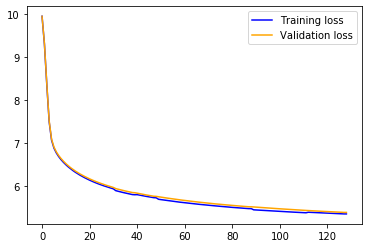

In [7]:
# Plot train/val loss

print(f'Final validation loss: { valRecord[-1] }')
print(f'Min validation loss:   { min(valRecord) }')

import matplotlib.pyplot as plt

epochIndex = np.arange(len(trainRecord))
plt.plot(epochIndex, trainRecord, color='blue', label='Training loss')
plt.plot(epochIndex, valRecord, color='orange', label='Validation loss')
plt.legend()
plt.show()


In [8]:
# Save model, optimizer, train/val sets, train/val record

### NOTE: start at epoch 0, batch 15744000
### NOTE: finished epoch 0, start new epoch

### NOTE: start at epoch 1, batch 11776000
### NOTE: finished epoch 1

SAVE_NAME = 'model_subsample_20M_2'

allTrainData = {
    'model': model,
    'optimizer': optimizer,
    'trainSets': (X_train, y_train),
    'valSets': (X_val, y_val),
    'trainRecord': trainRecord,
    'valRecord': valRecord,
}

import pickle
with open(SAVE_NAME + '.pkl', 'wb') as f:
    pickle.dump(allTrainData, f)

In [3]:
# Load model, optimizer, train/val sets, train/val record

LOAD_NAME = 'model_subsample_20M_2'

import pickle
with open(LOAD_NAME + '.pkl', 'rb') as f:
    savedData = pickle.load(f)
    
model = savedData['model']
optimizer = savedData['optimizer']
X_train, y_train = savedData['trainSets']
X_val, y_val = savedData['valSets']
trainRecord = savedData['trainRecord']
valRecord = savedData['valRecord']

In [13]:
# View predictions for data from the training set

# Get 30 random Xs, ys
testSize = 30
testSampleIndex = np.random.randint(0, X_train.shape[0], testSize)
testX = X_train[testSampleIndex]
testy = y_train[testSampleIndex]

# Get predictions
scores = model.forward(torch.LongTensor(testX))
yPred = np.argmax(scores.detach().numpy(), axis=1)
yPredWords = [inverse_vocabulary[i] for i in yPred]

# Get actuals
yTrueWords = [inverse_vocabulary[i] for i in testy]

# Print
print(f'{"Predicted":14}   :   {"Actual":14}   :   {"Equal?":6}')
print('-------------------------------------------------')
for p, a in zip(yPredWords, yTrueWords):
    print(f'{p:14}   :   {a:14}   :   {"Yes" if p == a else "No" :6}')





Predicted        :   Actual           :   Equal?
-------------------------------------------------
forward          :   forward          :   Yes   
construction     :   identification   :   No    
estimate         :   estimate         :   Yes   
reserve          :   serotonin        :   No    
follow           :   periods          :   No    
meet             :   hemophilia       :   No    
sell             :   opportunities    :   No    
primarily        :   increase         :   No    
revenue          :   period           :   No    
account          :   account          :   Yes   
fasb             :   account          :   No    
result           :   could            :   No    
litigation       :   losses           :   No    
cost             :   field            :   No    
party            :   party            :   Yes   
cash             :   cash             :   Yes   
revenues         :   grow             :   No    
report           :   begin            :   No    
approval         : 

In [17]:
# Save the word vectors from a model as a .npy file (numpy array)

np.save('model_subsample_20M_2_vectors.npy', model.embed.weight.data.numpy())

In [16]:
import time
start = time.time()
numRows = 10000
loss = record_loss(
    torch.LongTensor(X_full[:numRows]), 
    torch.LongTensor(y_full[:numRows]), 
    model, 
    F.cross_entropy, 
    None,
)
end = time.time()
print(f'Time to compute loss on { numRows } rows: { end - start } seconds')

Time to compute loss on 10000 rows: 5.13755202293396 seconds
